# Isogeometric analysis

We are here going to create a stiffness matrix and solve a differential equation using spline basis functions

### Create the geometry

We first create a simple geometry

In [1]:
%matplotlib notebook

In [2]:
from splipy import curve_factory, surface_factory
from numpy import pi, cos, sin
from scipy.special import roots_legendre
import matplotlib.pyplot as plt
import numpy as np

In [3]:
c1 = curve_factory.circle_segment(theta=np.pi/2).rebuild(p=3, n=3)
c2 = c1 * 2

surf = surface_factory.edge_curves([c2,c1])

In [4]:
def plot_2D_surface(surface):
    u = np.linspace(surface.start('u'), surface.end('u'), 30)
    v = np.linspace(surface.start('v'), surface.end('v'), 30)
    x = surface(u,surf.knots(1))
    plt.plot(x[:,:,0],   x[:,:,1],   'k-')
    
    x = surface(surf.knots(0),v)
    plt.plot(x[:,:,0].T, x[:,:,1].T, 'k-')
    plt.axis('equal')
    plt.show()
    
def plot_3D_surface(surface):
    u = np.linspace(surface.start('u'), surface.end('u'), 30)
    v = np.linspace(surface.start('v'), surface.end('v'), 30)
    x = surface(u,v)
    fig = plt.gcf()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(  x[:,:,0], x[:,:,1], x[:,:,2])
    ax.plot_wireframe(x[:,:,0], x[:,:,1], x[:,:,2], edgecolor='k', linewidth=1)
    plt.show()

<IPython.core.display.Javascript object>


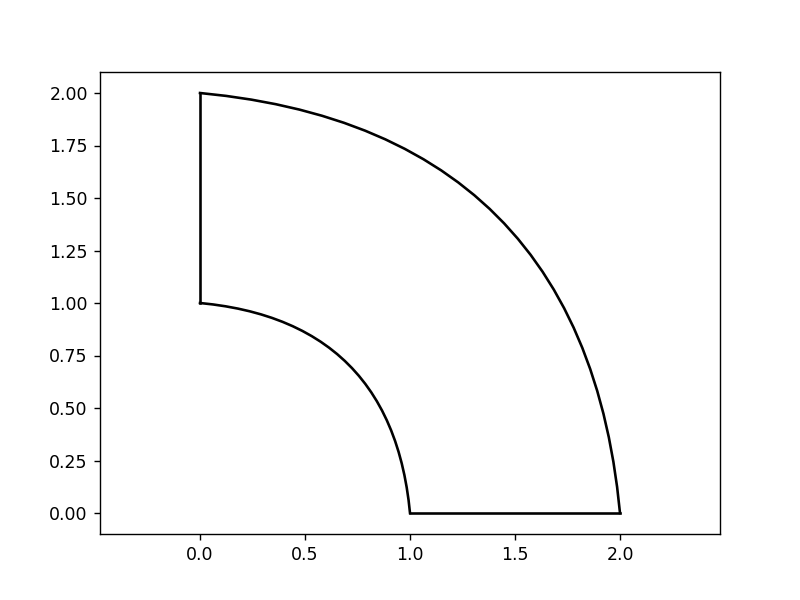

In [5]:
plot_2D_surface(surf)

# Refine the geometry
We can refine the representation to increase the accuracy

<IPython.core.display.Javascript object>


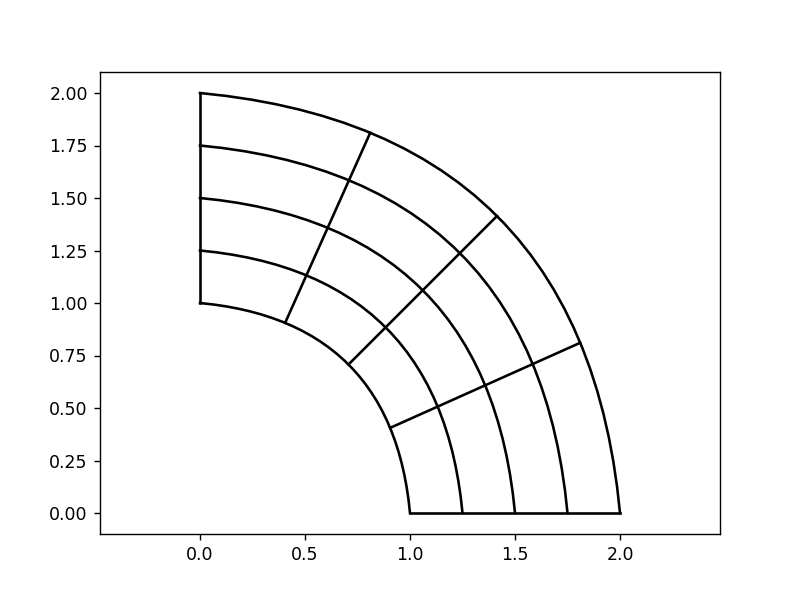

In [6]:
surf.refine(3) # insert 3 new knots into each existing element
plot_2D_surface(surf)

<IPython.core.display.Javascript object>


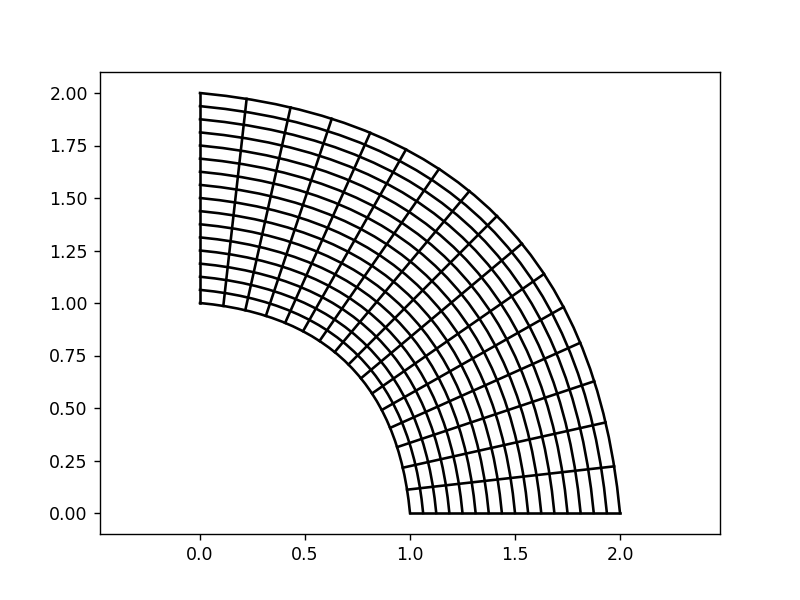

In [7]:
surf.refine(3) # insert 3 new knots into each existing element
plot_2D_surface(surf)

# Assemble the system matrix

We are now going to solve the partial differential equation Poisson problem:
$$ \nabla^2 u = f(x,y) $$
$$ u(x,y) = 0,  \forall (x,y)\in \Gamma$$
$$ f(x,y) = 1 $$

In [8]:
n = np.prod(surf.shape)  # number of basis functions
A = np.zeros((n,n))        # create a system matrix
b = np.zeros((1,n))        # create a right-hand side vector

# fetch gauss-legendre integration points
ng = 3 # number of gauss points
xi,w = roots_legendre(ng)

# for all elements
uknot = surf.knots(0)
vknot = surf.knots(1) 
for u0,u1 in zip(uknot[:-1], uknot[1:]):
    for v0,v1 in zip(vknot[:-1], vknot[1:]):
        
        # for all gaussian quadrature points
        for i in range(ng):
            for j in range(ng):
                # compute the parametric evaluation point
                u = u0 + (u1-u0)*(xi[i]+1)/2
                v = v0 + (v1-v0)*(xi[j]+1)/2

                # compute the basis functions and their derivative
                N    = np.tensordot(surf.bases[0](u, d=0),  surf.bases[1](v, d=0), axes=0).flatten()
                dNdu = np.tensordot(surf.bases[0](u, d=1) , surf.bases[1](v, d=0), axes=0).flatten()
                dNdv = np.tensordot(surf.bases[0](u, d=0) , surf.bases[1](v, d=1), axes=0).flatten()
                dNdu = np.vstack((dNdu, dNdv))

                # compute the geometric mapping and its derivative
                du = surf.derivative(u,v,d=(1,0))
                dv = surf.derivative(u,v,d=(0,1))
                J = np.vstack((du,dv))
                
                # chain rule differentiation to compute physical derivatives
                dNdx = np.linalg.inv(J.T) @ dNdu
                
                # assemble contributions to global system matrix and rhs
                A = A + dNdx.T @ dNdx * np.linalg.det(J) * w[i]*w[j]
                b = b + N             * np.linalg.det(J) * w[i]*w[j]
                
b = b.T # convenience resize 

<IPython.core.display.Javascript object>


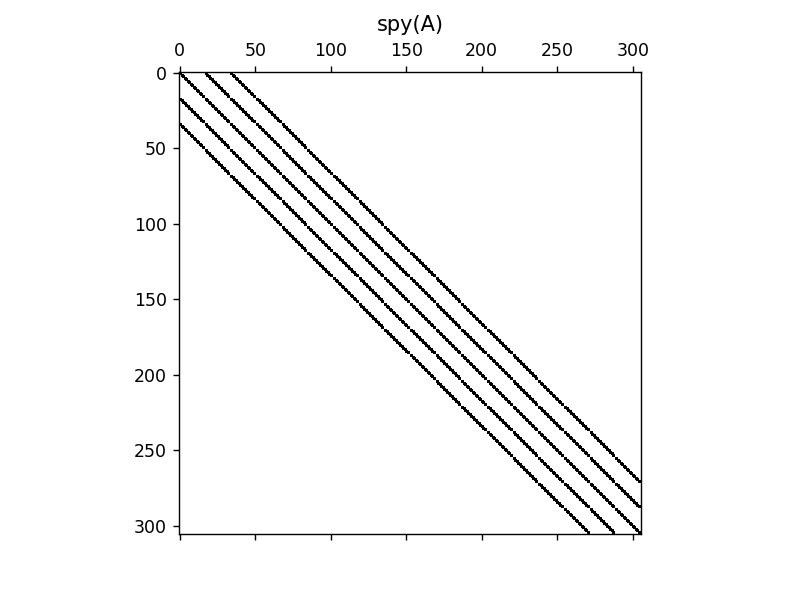

In [9]:
plt.spy(A)
plt.title('spy(A)')
plt.show()

verify that the system matrix has exactly one zero eigenvalue; corresponding to the undefined constant C in the family of solutions $u(x,y) = u_0(x,y)+C$ without specifying the boundary conditions.

In [10]:
e,v = np.linalg.eig(A)
print(np.sort(e))

[-7.90678450e-13  1.69675848e+01  3.39315028e+01  6.48331640e+01
  7.31962797e+01  1.09925369e+02  1.28518111e+02  1.46479774e+02
  1.84037312e+02  2.17717821e+02  2.27170847e+02  2.35276604e+02
  2.94214024e+02  3.00146699e+02  3.08204790e+02  3.34030852e+02
  3.66856185e+02  3.83483078e+02  3.87536509e+02  4.21381417e+02
  4.23697387e+02  4.53038509e+02  4.65573971e+02  4.87999062e+02
  5.06276754e+02  5.21245167e+02  5.30488851e+02  5.35637592e+02
  5.43672596e+02  5.72731014e+02  5.96527004e+02  6.04963796e+02
  6.18162160e+02  6.23238798e+02  6.24803247e+02  6.52802277e+02
  6.68100675e+02  6.76602328e+02  6.84447516e+02  6.93770412e+02
  7.04228000e+02  7.14677098e+02  7.24885109e+02  7.34071546e+02
  7.41415433e+02  7.49368173e+02  7.54119403e+02  7.73864570e+02
  7.81874546e+02  7.92816407e+02  8.00603617e+02  8.07648864e+02
  8.14685118e+02  8.35667865e+02  8.36627905e+02  8.46101841e+02
  8.57459267e+02  8.72861117e+02  8.79153606e+02  8.84034613e+02
  8.90293867e+02  8.90937

## Specify the boundary conditions

We specify homogenuous boundary conditions by setting all boundary functions to zero

In [11]:
surf.shape

(18, 17)

In [12]:
for i in range(18):
    A[i,:] = 0
    A[:,i] = 0
    A[i,i] = 1
    b[i] = 0

## Solve the linear system of equations

We solve $Au = b$

In [13]:
u = np.linalg.solve(A,b)

## Wrap the solution into the surface object and display

We first reshape the solution vector so it fits the same dimensions as the geometry object and then add this as the third dimension of the control points. This will allow us to draw the soluiton as a surface plot in 3D.

In [17]:
U = np.reshape(u, (18,17))

In [18]:
surf.set_dimension(3)
surf[:,:,-1] = U

<IPython.core.display.Javascript object>


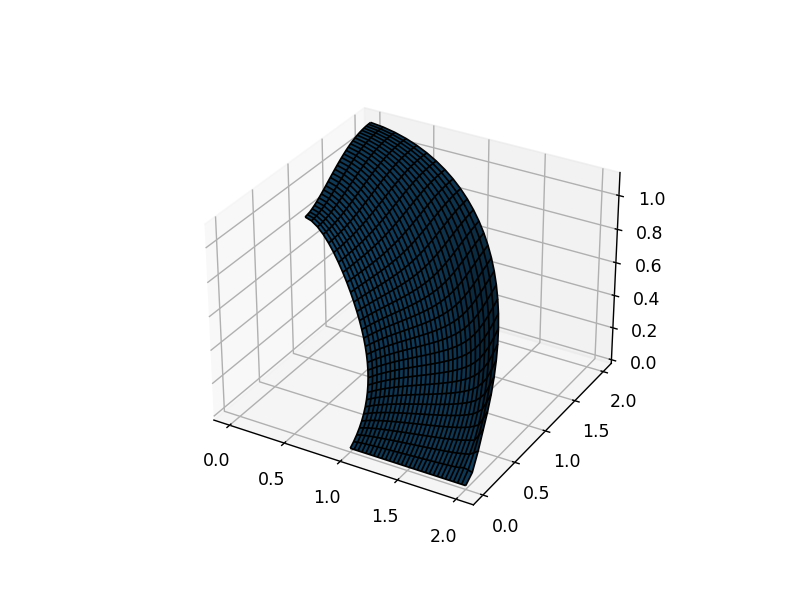

In [16]:
plot_3D_surface(surf)